In [1]:
from semra.analysis.landscape import notebook, get_mesh_category_curies

/Users/cthoyt/.virtualenvs/indra/lib/python3.11/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [3]:
# some resources are generic, so we want to cut to a relevant subset
subsets = {
    "mesh": [*get_mesh_category_curies("C"), *get_mesh_category_curies("F")],
    "efo": ["efo:0000408"],
    "ncit": ["ncit:C2991"],
}

## Summarize the Resources

We summarize the resources used in the landscape analysis, including their [Bioregistry](https://bioregistry.io)
prefix, license, current version, and number of terms (i.e., named concepts) they contain.


10 resources were not available through 
[PyOBO](https://github.com/biopragmatics/pyobo) and therefore list zero terms.


,name,license,version,terms
prefix,,,,
doid,Human Disease Ontology,CC0-1.0,2024-02-28,11511
mondo,Mondo Disease Ontology,CC-BY-4.0,2024-03-04,24099
efo,Experimental Factor Ontology,Apache-2.0,3.64.0,2082
mesh,Medical Subject Headings,CC0-1.0,2024,3120
ncit,NCI Thesaurus,CC-BY-4.0,24.02d,20094
umls,Unified Medical Language System Concept Unique...,None,2023AB,3185657
orphanet,Orphanet,None,None,0
orphanet.ordo,Orphanet Rare Disease Ontology,CC-BY-4.0,4.4,0
omim,Online Mendelian Inheritance in Man,None,"March 26, 2024",0


## Summarize the Mappings

In order to summarize the mappings, we're going to load them, index them, and count
the number of mappings between each pair of resources. The self-mapping column is
the count of terms in the resource. We'll do this to the raw mappings first, then
to the processed mappings, then compare them.


First, we summarize the raw mappings, i.e., the mappings that are directly available from the sources

target_prefix,doid,mondo,efo,mesh,ncit,umls,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd11,icd9,icd9cm,icdo
source_prefix,,,,,,,,,,,,,,,,
doid,11511,11150,2189,4612,4612,7034,2108,5898,0,2109,0,3528,1,0,2237,470
mondo,11150,24099,3070,8137,7193,14722,9529,9871,582,11838,15,1637,0,4343,2,732
efo,2189,3070,2082,1073,2197,2234,58,850,42,733,804,443,0,1766,7,323
mesh,4612,8137,1073,3120,142,2,0,0,0,0,0,0,0,0,0,0
ncit,4612,7193,2197,142,20094,0,0,0,0,0,0,0,0,0,0,0
umls,7034,14722,2234,2,0,3185657,9007,0,0,0,0,0,0,0,0,0
orphanet.ordo,2108,9529,58,0,0,9007,0,11146,0,0,7623,0,5484,0,0,0
omim,5898,9871,850,0,0,0,11146,0,0,0,0,0,0,0,0,0
omim.ps,0,582,42,0,0,0,0,0,0,0,0,0,0,0,0,0


Next, we summarize the processed mappings, which include inference, reasoning, and confidence filtering.

target_prefix,doid,mondo,efo,mesh,ncit,umls,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd11,icd9,icd9cm,icdo
source_prefix,,,,,,,,,,,,,,,,
doid,11511,11365,2278,4660,5094,0,2508,5917,81,2109,11,3599,1,0,2237,470
mondo,11365,24099,3248,8279,7460,0,9545,9874,583,11839,15,1662,0,4343,4,732
efo,2278,3248,2082,1197,2375,0,387,872,48,733,805,488,0,1766,7,323
mesh,4660,8279,1197,3120,1585,0,612,1288,47,1,5,470,0,0,1,0
ncit,5094,7460,2375,1585,20094,0,585,217,52,2,9,536,0,0,1,0
umls,0,0,0,0,0,3185657,0,0,0,0,0,0,0,0,0,0
orphanet.ordo,2508,9545,387,612,585,0,0,11172,71,1,7623,193,5484,0,1,0
omim,5917,9874,872,1288,217,0,11172,0,4,2,1,50,0,0,1,0
omim.ps,81,583,48,47,52,0,71,4,0,1,0,19,0,0,1,0


Below is an graph-based view on the processed mappings.

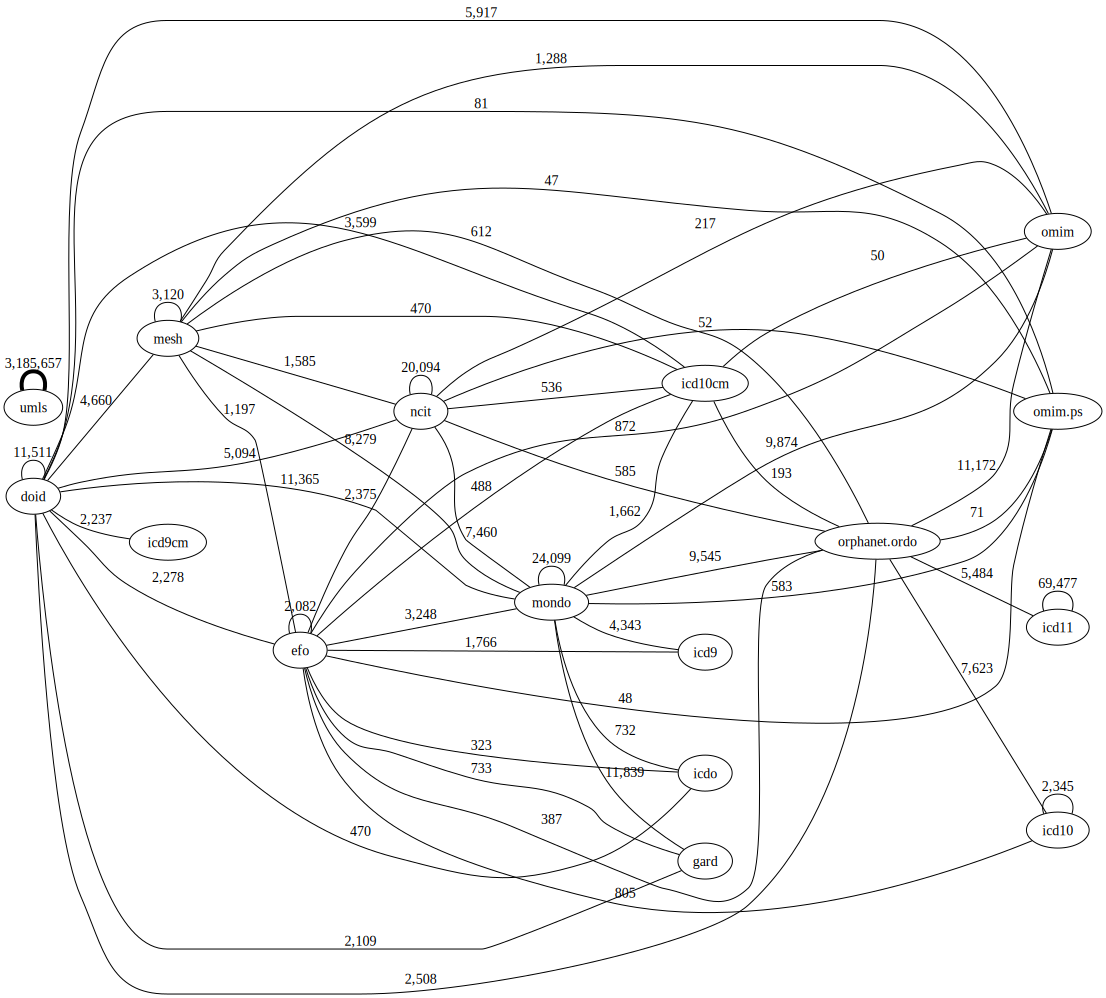

## Comparison

The following comparison shows the absolute number of mappings added by processing/inference.
Across the board, this process adds large numbers of mappings to most resources, especially
ones that were previously only connected to a small number of other resources.


target_prefix,doid,mondo,efo,mesh,ncit,umls,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd11,icd9,icd9cm,icdo
source_prefix,,,,,,,,,,,,,,,,
doid,0,215,89,48,482,-7034,400,19,81,0,11,71,0,0,0,0
mondo,215,0,178,142,267,-14722,16,3,1,1,0,25,0,0,2,0
efo,89,178,0,124,178,-2234,329,22,6,0,1,45,0,0,0,0
mesh,48,142,124,0,1443,-2,612,1288,47,1,5,470,0,0,1,0
ncit,482,267,178,1443,0,0,585,217,52,2,9,536,0,0,1,0
umls,-7034,-14722,-2234,-2,0,0,-9007,0,0,0,0,0,0,0,0,0
orphanet.ordo,400,16,329,612,585,-9007,0,26,71,1,0,193,0,0,1,0
omim,19,3,22,1288,217,0,26,0,4,2,1,50,0,0,1,0
omim.ps,81,1,6,47,52,0,71,4,0,1,0,19,0,0,1,0


Here's an alternative view on the number of mappings normalized to show percentage gain.

Note:

- `inf` means that there were no mappings before and now there are a non-zero number of mappings
- `NaN` means there were no mappings before inference and continue to be no mappings after inference


target_prefix,doid,mondo,efo,mesh,ncit,umls,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd11,icd9,icd9cm,icdo
source_prefix,,,,,,,,,,,,,,,,
doid,0.0,1.9,4.1,1.0,10.5,-100.0,19.0,0.3,inf,0.0,inf,2.0,0.0,NaN,0.0,0.0
mondo,1.9,0.0,5.8,1.7,3.7,-100.0,0.2,0.0,0.2,0.0,0.0,1.5,NaN,0.0,100.0,0.0
efo,4.1,5.8,0.0,11.6,8.1,-100.0,567.2,2.6,14.3,0.0,0.1,10.2,NaN,0.0,0.0,0.0
mesh,1.0,1.7,11.6,0.0,1016.2,-100.0,inf,inf,inf,inf,inf,inf,NaN,NaN,inf,NaN
ncit,10.5,3.7,8.1,1016.2,0.0,NaN,inf,inf,inf,inf,inf,inf,NaN,NaN,inf,NaN
umls,-100.0,-100.0,-100.0,-100.0,NaN,0.0,-100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
orphanet.ordo,19.0,0.2,567.2,inf,inf,-100.0,NaN,0.2,inf,inf,0.0,inf,0.0,NaN,inf,NaN
omim,0.3,0.0,2.6,inf,inf,NaN,0.2,NaN,inf,inf,inf,inf,NaN,NaN,inf,NaN
omim.ps,inf,0.2,14.3,inf,inf,NaN,inf,inf,NaN,inf,NaN,inf,NaN,NaN,inf,NaN


## Landscape Analysis

Before, we looked at the overlaps between each resource. Now, we use that information jointly to
estimate the number of terms in the landscape itself, and estimate how much of the landscape
each resource covers.


KeyError: 'umls'

In [4]:
notebook(CONFIGURATION, subsets)